In [1]:
import sys

sys.path.insert(0, "..")

In [2]:
from pprint import pprint
import os
import tomllib
from pathlib import Path

from src.utils import setup_dirs

root_dir = Path(os.getcwd()).parent
data_dir, log_dir, out_dir = setup_dirs(root_dir)
data_dir = data_dir / "ACDC" / "database"

with open(root_dir / "config.toml", "rb") as file:
    config = tomllib.load(file)

pprint(config)

{'hyperparameters': {'epochs': 100,
                     'learning_rate': 1e-05,
                     'percentage_data': 1.0,
                     'seed': 42,
                     'validation_split': 0.8}}


In [3]:
from monai.utils import set_determinism

from src.datasets.acdc_dataset import ACDCDataset

import importlib
import sys

importlib.reload(sys.modules['src.transforms'])
from src.transforms import get_transforms

set_determinism(seed=config["hyperparameters"]["seed"])

train_transforms = get_transforms("end_diastole", "end_diastole_label")
train_data = ACDCDataset(data_dir=data_dir, train=True, transform=train_transforms, full_volume=True)

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-03-13 11:17:29,774 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
torch.Size([224, 256, 16, 32])


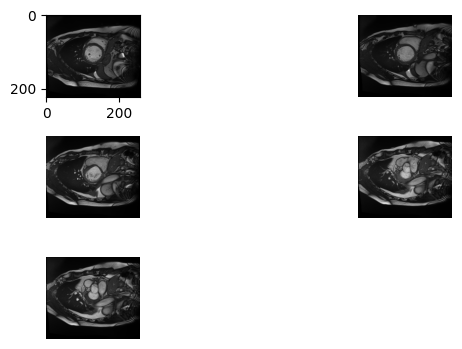

In [4]:
from matplotlib import pyplot as plt

data = train_data[0]
full_volume = data["full_volume"][0]
print(full_volume.shape)
first_volume = full_volume[:, :, :, 0]
second_volume = full_volume[:, :, :, 5]

for volume_index in range(4):
    plt.subplot(4, 2, volume_index + 1)
    plt.imshow(first_volume[:, :, volume_index], cmap="gray")
    plt.subplot(4, 2, volume_index + 2)
    plt.imshow(second_volume[:, :, volume_index], cmap="gray")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [5]:
from monai.networks.layers import Norm
from monai.networks.blocks import Warp
from monai.networks.nets import UNet
import torch
from torch.nn import MSELoss
from torch.utils.data import DataLoader

train_loader = DataLoader(train_data, batch_size=1, shuffle=False, num_workers=1)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = UNet(
    spatial_dims=2,
    in_channels=2,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    norm=Norm.INSTANCE,
).to(device)

warp_layer = Warp(mode="bilinear", padding_mode="border").to(device)
loss_function = MSELoss()
optimizer = torch.optim.Adam(model.parameters())

/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/monai/networks/blocks/warp.py:66: UserWarning: monai.networks.blocks.Warp: Using PyTorch native grid_sample.
  warnings.warn("monai.networks.blocks.Warp: Using PyTorch native grid_sample.")


In [14]:
import statistics

max_epochs = 200
epoch_loss_values = []

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss, step = 0, 0
    for batch_data in train_loader:
        step += 1
        optimizer.zero_grad()

        # Get only the volume at the 0th time
        # B, C, H, W, D, T
        # TODO: permute?
        full_volume = batch_data["full_volume"].to(device)
        first_volume = full_volume[:, :, :, :, :, 0]
        _, _, _, _, slices = first_volume.shape

        slice_losses = []
        for slice_index in range(slices - 1):
            # TODO: instead of only looking one slice in the future, we can look n weighted slices
            fixed = first_volume[:, :, :, :, slice_index]
            moving = first_volume[:, :, :, :, slice_index + 1]

            ddf = model(torch.cat((moving, fixed), dim=1))
            pred_image = warp_layer(moving, ddf)

            slice_loss = loss_function(pred_image, fixed)
            slice_loss.backward()
            optimizer.step()
            slice_losses.append(slice_loss)

        # Take the mean loss over all slices
        epoch_loss += statistics.fmean(slice_losses)

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

----------
epoch 1/200


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-03-13 11:36:32,624 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/monai/data/__init__.py:127: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if storage.is_cuda:
/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/monai/data/__init__.py:120: UserWarning: TypedStorage is deprecated. It will be removed in the future and

2023-03-13 11:36:35,411 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-03-13 11:36:38,626 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-03-13 11:36:41,559 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-03-13 11:36:44,281 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-03-13 11:36:46,965 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-03-13 11:36:49,795 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-03-13 11:36:50,821 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-03-13 11:37:17,984 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-03-13 11:37:20,439 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-03-13 11:37:22,473 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-03-13 11:37:24,714 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-03-13 11:37:26,813 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-03-13 11:37:29,661 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-03-13 11:37:31,935 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-03-13 11:37:34,188 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-03-13 11:37:36,456 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-03-13 11:37:38,359 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-03-13 11:37:42,008 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-03-13 11:37:44,163 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-03-13 11:37:46,542 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-03-13 11:38:11,596 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-03-13 11:38:16,395 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-03-13 11:38:28,172 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-03-13 11:38:31,728 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


KeyboardInterrupt: 